## Configuration and Exploratory Analysis of the SPLINK Model

This notebook contains the configuration and exploratory analysis for using the [SPLINK](https://moj-analytical-services.github.io/splink/index.html) model to run a record linkage algorithm.
The goal is to execute this model after receiving results from [OpenSearch](https://opensearch.org/).

In general, the idea is to perform the following steps when someone queries the `GET /v1/production-locations/` endpoint with the name and address of the production location:

1. First, query the OpenSearch cluster's `production-locations` index using [hybrid search](https://opensearch.org/docs/latest/vector-search/ai-search/hybrid-search/index/).

2. After obtaining the search results, use the [real-time record linkage](https://moj-analytical-services.github.io/splink/demos/examples/duckdb/real_time_record_linkage.html) capability of the SPLINK library to generate confidence scores for potential matches.


In [1]:
# add default imports
import opensearchpy as osp
import pandas as pd
import splink as spl
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/50/vz4zppy91kzfpwhm72yqttv80000gn/T/ipykernel_86254/2716884702.py:4: DeprecationWarning: Python 3.8 has reached end-of-life.  Future releases of Splink may no longer be compatible with this python version.
Please consider upgrading your python version if you wish to continue to be able to install the latest version of Splink.
  import splink as spl


## Exploratory data analysis

### 1. Load the data from csv

In [2]:
locs_df = pd.read_csv("production_locations.csv")
locs_df = locs_df.drop(columns=[
    "created_at",
    "updated_at",
    "potential_match_score",
    "potential_match_os_id",
    "found_index"
])

### 2. Print data frame info

In [3]:
locs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1118341 entries, 0 to 1118340
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   os_id                   1118341 non-null  object 
 1   name                    1118341 non-null  object 
 2   address                 1118339 non-null  object 
 3   lat                     1118341 non-null  float64
 4   lng                     1118341 non-null  float64
 5   geo_hash                1118341 non-null  object 
 6   country_code            1118331 non-null  object 
 7   found_score             1118341 non-null  float64
 8   geocoded_location_type  1027110 non-null  object 
 9   geocoded_address        1027110 non-null  object 
dtypes: float64(3), object(7)
memory usage: 85.3+ MB


### 3. Plot top countries and location types

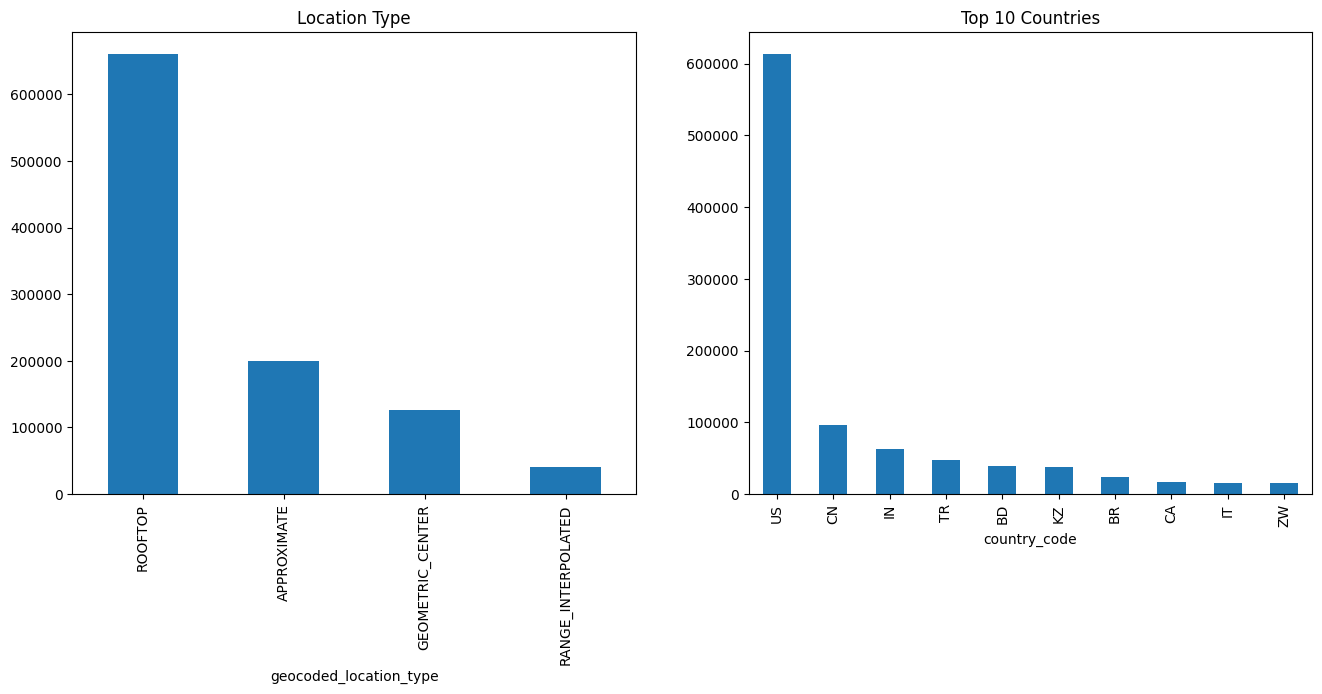

In [4]:
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
locs_df['geocoded_location_type'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].set_title('Location Type')
locs_df['country_code'].value_counts().sort_values(ascending=False)[
    :10].plot(kind='bar', ax=ax[1])
ax[1].set_title('Top 10 Countries')
plt.show()

### 4. Profile completeness of the data

In [5]:
from splink.exploratory import completeness_chart
from splink import DuckDBAPI

completeness_chart(locs_df, db_api=DuckDBAPI())

alt.LayerChart(...)

### 5. Analyze data distribution

In [6]:
from splink.exploratory import profile_columns

profile_columns(locs_df, db_api=DuckDBAPI(), top_n=10, bottom_n=5)

alt.VConcatChart(...)